In [1]:
import pandas as pd
import numpy as np 
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.data.experimental import AUTOTUNE

from tensorflow.python.client import device_lib
from sklearn import linear_model
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import time
import math
from PIL import Image
# for the dropout
from keras.layers import Lambda
from keras import backend as K


# pour le max_pooling en profondeur
class MaxDepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        old_shape = tf.shape(inputs)
        num_channels = old_shape[-1]
        num_channel_groups = num_channels // self.pool_size
        new_shape = tf.concat(
            [old_shape[:-1], [num_channel_groups, self.pool_size]], axis=0)
        reshaped_inputs = tf.reshape(inputs, new_shape)
        return tf.reduce_max(reshaped_inputs, axis=-1)

# pour le mean_pooling en profondeur
class MeanDepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        old_shape = tf.shape(inputs)
        num_channels = old_shape[-1]
        num_channel_groups = num_channels // self.pool_size
        new_shape = tf.concat(
            [old_shape[:-1], [num_channel_groups, self.pool_size]], axis=0)
        reshaped_inputs = tf.reshape(inputs, new_shape)
        return tf.reduce_mean(reshaped_inputs, axis=-1)

# pour le dropout permanent
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))
file_name = "./emirhan_human_dataset/datasets/human_data/train_data"

Link to dataset: https://www.kaggle.com/datasets/emirhanai/human-action-detection-artificial-intelligence

In [2]:
list_files = glob.glob(file_name+"/*/*") # chargement de la liste des fichiers
resolution = [224,224] # la resolution avec laquelle on va travailler

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
image_ds = tf.data.Dataset.list_files(file_name+"/*/*",seed=42) # lecture path de mes images
image_ds = image_ds.filter(lambda path: tf.strings.split(path,sep=".")[-1]== "jpg")

# dictionnaire des position
dict_position = [b'calling',b'clapping',b'cycling',b'dancing',b'drinking',b'eating',b'fighting',b'hugging',b'laughing',
                 b'listening_to_music',b'running',b'sitting',b"sleeping",b'texting',b'using_laptop']

In [4]:
for element in image_ds.take(10):
    print(element)

tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/sitting/images_142 (3).jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/fighting/images_328.jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/sleeping/images_269.jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/listening_to_music/images_187 (2).jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/hugging/images_368 (2).jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/laughing/images_424.jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/dancing/images_365.jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datasets/human_data/train_data/hugging/images_383 (2).jpg', shape=(), dtype=string)
tf.Tensor(b'./emirhan_human_dataset/datase

In [5]:
def retrieve_label(path):
    return tf.strings.split(path,sep="/")[-2]

for element in image_ds.map(retrieve_label).take(5):
    print(element)

tf.Tensor(b'fighting', shape=(), dtype=string)
tf.Tensor(b'using_laptop', shape=(), dtype=string)
tf.Tensor(b'sitting', shape=(), dtype=string)
tf.Tensor(b'fighting', shape=(), dtype=string)
tf.Tensor(b'listening_to_music', shape=(), dtype=string)


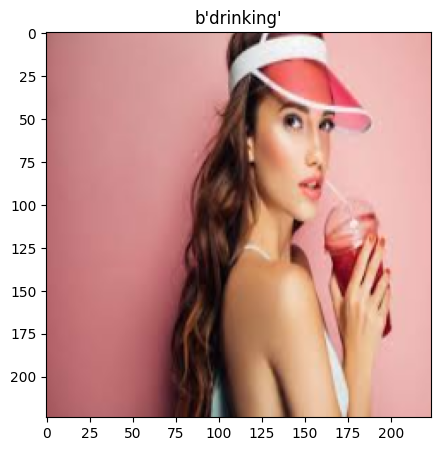

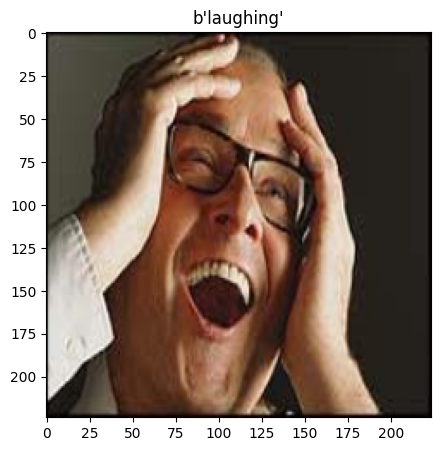

In [6]:
def preprocess_path_to_img(path,dict_position=dict_position):
    label = retrieve_label(path)
    img = tf.io.read_file(path) 
    img = tf.image.decode_jpeg(img)  # lecture image
    img = tf.image.convert_image_dtype(img,tf.float32) # equivalent a divier par 255
    img = tf.image.resize(img,size=resolution) # resize de l'image
    label = tf.cast(tf.math.equal(label,dict_position),tf.int16)
    return img,label



for img,label in image_ds.map(preprocess_path_to_img).take(2):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(dict_position[np.argmax(label)])
    plt.show()

In [7]:
# preprocessing des image
image_preprocess_ds = image_ds.map(preprocess_path_to_img,num_parallel_calls=AUTOTUNE)

# definition de la taille du dataset
ind = 0
for element in image_preprocess_ds:
    ind += 1

image_preprocess_ds = image_preprocess_ds.apply(tf.data.experimental.assert_cardinality(ind)) # on definit la longueur du dataset
    

In [8]:
def augment(img_label,seed):
    img,label = img_label # recuperation image et label
    if tf.random.uniform((),minval=0,maxval=10) < 5:
        img = tf.image.flip_left_right(img)
    if tf.random.uniform((),minval=0,maxval=10) < 3:
        img = tf.image.stateless_random_brightness(img,max_delta=0.3,seed=seed)
    if tf.random.uniform((),minval=0,maxval=10) < 2:
        img = tf.image.stateless_random_contrast(img,lower=0.5,upper=0.9,seed=seed)
    temp_seed= tf.random.uniform((),minval=0,maxval=100)
    if temp_seed < 17:
        img = tf.image.rot90(img,k=1)
    elif temp_seed < 33 and temp_seed >=17:
        img = tf.image.rot90(img,k=2)
    elif temp_seed < 48 and temp_seed >= 33:
        img = tf.image.rot90(img,k=3)
    if tf.random.uniform((),minval=0,maxval=10) < 2:
        img = tf.image.stateless_random_crop(img,size=(180,180,3),seed=seed)
        img = tf.image.resize(img,size=resolution,preserve_aspect_ratio=True)
    img = tf.clip_by_value(img,0,1)
    return img,label

# Create a wrapper function for updating seeds.

rng = tf.random.Generator.from_seed(42)  # Replace 42 with your desired seed


def augment_rng(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label


In [9]:
print(tf.__version__)

2.7.0


In [10]:
size = len(image_preprocess_ds)
test_size = size//100*85
train_ds = image_preprocess_ds.take(test_size)
validation_dataset = image_preprocess_ds.skip(test_size)

# augmentation des données
augmented_image_ds = train_ds.map(augment_rng, num_parallel_calls=4)  # Example with 4 parallel calls

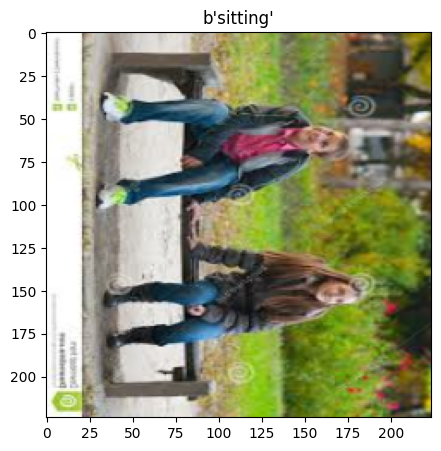

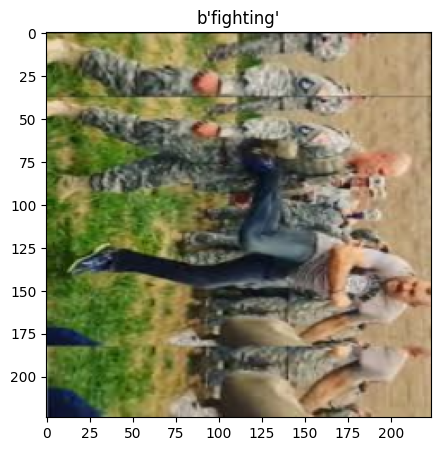

In [11]:
for img,label in augmented_image_ds.take(2):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(dict_position[np.argmax(label)])
    plt.show()

In [12]:
batch_size = 32 # taille des minilot
image_preprocess_ds = image_preprocess_ds.batch(batch_size=batch_size,drop_remainder=True).prefetch(1)
validation_dataset = validation_dataset.batch(batch_size=batch_size,drop_remainder=True).prefetch(1)

In [13]:
for img,label in image_preprocess_ds.take(1):
    print(label)

tf.Tensor(
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]

In [19]:
Xception_model = tf.keras.applications.vgg19.VGG19(input_shape=[resolution[0],resolution[1],3],include_top=False,weights='imagenet')
Xception_model.trainable = False

model_1 = tf.keras.Sequential([
    Xception_model,
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(15,activation="softmax")
])


# compilation du modèle
model_1.compile(
    # loss = tf.keras.losses.MeanSquaredError(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics = "accuracy")

In [20]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                                 
Total params: 33,005,135
Trainable params: 12,980,751
Non-trainable params: 20,024,384
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# ... other code ...

# Check data shape (uncomment to verify)
print(next(iter(image_preprocess_ds))[0][0].shape)

# Reshape data if necessary (adjust if the actual shape differs)
if next(iter(image_preprocess_ds))[0][0].shape != (224, 224, 3):
    image_preprocess_ds = image_preprocess_ds.map(lambda x, y: (tf.reshape(x, (224, 224, 3)), y))
# Training
early_stop = EarlyStopping(monitor='val_accuracy', 
                           min_delta=0.001, 
                           patience=20, 
                           restore_best_weights=True)

history = model_1.fit(image_preprocess_ds, epochs=100, validation_data=validation_dataset, callbacks=early_stop)

(224, 224, 3)
Epoch 1/100
468/468 [==============================] - 30s 62ms/step - loss: 101.9265 - accuracy: 0.3554 - val_loss: 2.8266 - val_accuracy: 0.5250
Epoch 2/100
468/468 [==============================] - 29s 63ms/step - loss: 3.5525 - accuracy: 0.5154 - val_loss: 3.1923 - val_accuracy: 0.5830
Epoch 3/100
468/468 [==============================] - 29s 62ms/step - loss: 3.1330 - accuracy: 0.5676 - val_loss: 1.4414 - val_accuracy: 0.6929
Epoch 4/100
468/468 [==============================] - 29s 63ms/step - loss: 1.4329 - accuracy: 0.6974 - val_loss: 1.1683 - val_accuracy: 0.7317
Epoch 5/100
468/468 [==============================] - 29s 63ms/step - loss: 1.9313 - accuracy: 0.6847 - val_loss: 1.7085 - val_accuracy: 0.7063
Epoch 6/100
468/468 [==============================] - 29s 63ms/step - loss: 1998.0566 - accuracy: 0.5286 - val_loss: 470.4604 - val_accuracy: 0.4960
Epoch 7/100
468/468 [==============================] - 29s 63ms/step - loss: 161.9644 - accuracy: 0.5765 - va

In [17]:
print(next(iter(image_preprocess_ds))[0].shape)

(32, 224, 224, 3)


In [25]:
model_1.save("VGG19.h5")

In [26]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) +1) 

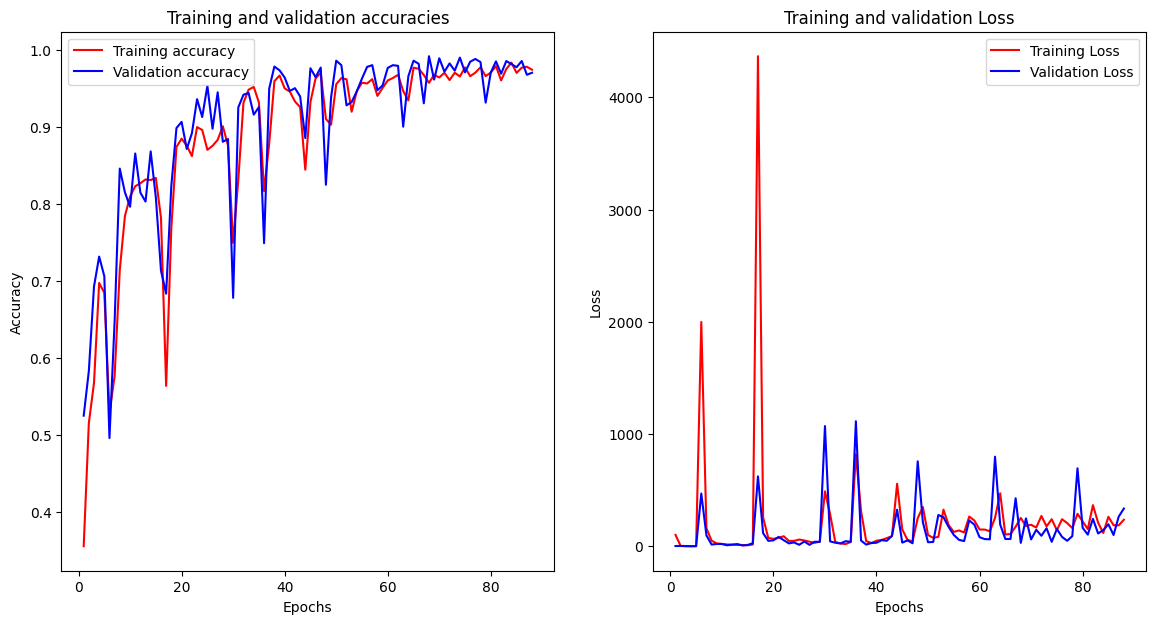

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (14, 7))

ax[0].plot(epochs, accuracy, 'r', label = 'Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
ax[0].set_title('Training and validation accuracies')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()


ax[1].plot(epochs, loss_values, 'r', label = 'Training Loss')
ax[1].plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
ax[1].set_title('Training and validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()